# Práctica Machine Learning

## Primera iteración

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_finance import candlestick2_ohlc
import pickle

C:\Users\MARIO\anaconda3\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


### Datos

Se obtienen las series históricas del IBEX con formato pickle.

In [2]:
with open('benchmark_data.pkl', 'rb') as handle:
    bm = pickle.load(handle)
ibex = bm['ibex']
ibex

,close,high,low,open,vol
2000-01-03,11610.0,11881.8,11574.4,11846.6,60107000.0
2000-01-04,11206.6,11530.0,11159.8,11499.5,62539000.0
2000-01-05,10863.1,11068.1,10824.9,11206.6,68153000.0
2000-01-07,11102.4,11137.9,10882.7,10963.4,144207000.0
2000-01-10,11173.3,11364.3,11120.6,11363.8,133817000.0
...,...,...,...,...,...
2019-06-04,9117.6,9138.5,8964.2,8972.7,197017094.0
2019-06-05,9150.5,9173.4,9095.0,9136.8,158753002.0
2019-06-06,9169.2,9246.2,9136.7,9169.2,212720881.0
2019-06-07,9236.1,9261.4,9185.7,9186.7,150664687.0


### Bucle etiquetado

Este es el bucle utilizado para etiquetar las ventanas aleatorias. Es el mismo bucle que se encuentra en el notebook de etiquetado de patrones provisto y con el que se han etiquetado las ventanas y obtenido los datos para entrenar y testear el modelo de clasificación creado. Se establece el patron de doble suelo con la etiqueta 1 y un no patrón con el 0. Para el doble suelo se han considerado solo los estricamente iguales al ejemplo dado en el enunciado.

In [3]:
def bucle_etiquetado (n,window):
    etiquetas = np.zeros(n)
    idfechas = np.zeros(n)
    for i in range(n):
        idx = np.random.randint(0, ibex.shape[0] - window)
        idfechas[i] = idx
        windata = ibex.iloc[idx:idx+window]
        fig, ax = plt.subplots(figsize=(6,4))
        _ = candlestick2_ohlc(ax, windata.open, windata.high,
                             windata.low, windata.close,
                             colorup='g', colordown='r', width=0.66, alpha=0.8)
        plt.show()
        print(f'Ejemplo {i+1} de {n}')
        print("Etiquete la siguiete grafica como:")
        print(" [1] Doble suelo, [0] Sin doble suelo, [2] Descartar ejemplo")
        opcion_usuario = input()
        if opcion_usuario >= '0' and opcion_usuario <= '2':
            etiquetas[i] = opcion_usuario   
        else:
            print('Error en la opción introducida. Ejemplo descartado')
            etiquetas[i] = 2
    doble_suelo_labels = pd.Series(etiquetas, index=ibex.index[idfechas.astype(int)])
    doble_suelo_labels = doble_suelo_labels[doble_suelo_labels!=2]
    doble_suelo_labels = pd.DataFrame(doble_suelo_labels).reset_index()
    doble_suelo_labels.columns = ['fecha','etiqueta']
    return doble_suelo_labels

### Características

Retorno de las series de precios etiquetadas 

In [5]:
def retorno_ventana(data):
    r = data.close.iloc[-1]/data.close.iloc[0] - 1
    return r 

Número de días que pasan entre el precio máximo y el mínimo de la ventana

In [6]:
def dif_dias_max_min (data):
    
    dia_max = data["close"][data["close"] == data["close"].max()].index[0]
    dia_min = data["close"][data["close"] == data["close"].min()].index[0]
    dif_dias = dia_max - dia_min
    return abs(dif_dias.days)

Número de veces en la ventana que cruza un umbral inferior

In [7]:
def cruce_umbral (data,porcent_umbral = 0.1):
    
    precio_min = data["close"][data["close"] == data["close"].min()].values
    precio_max = data["close"][data["close"] == data["close"].max()].values
    umbral = precio_min + porcent_umbral*(precio_max-precio_min)
    n_datos_inf_umbral = data.close[data.close <= umbral[0]].shape[0]
    return n_datos_inf_umbral

Orden del máximo y el mínimo (cual ocurre primero)

In [8]:
def orden_max_min (data):
    
    dia_max = data["close"][data["close"] == data["close"].max()].index[0]
    dia_min = data["close"][data["close"] == data["close"].min()].index[0]
    
    if dia_max > dia_min :
        etiqueta = 1
    else:
        etiqueta = 0
    
    return etiqueta

Número de veces en la ventana que cruza un umbral superior

In [9]:
def cruce_umbral2 (data,porcent_umbral = 0.1):
    
    precio_min = data["close"][data["close"] == data["close"].min()].values
    precio_max = data["close"][data["close"] == data["close"].max()].values
    umbral = precio_max - porcent_umbral*(precio_max-precio_min)
    n_datos_inf_umbral = data.close[data.close >= umbral[0]].shape[0]
    return n_datos_inf_umbral

Coeficiente de variación
    

In [153]:
def coef_variacion (data):
    
    desv = data.close.std()
    media = data.close.mean()
    return desv/media

### Datos training/test

Se dividiran los datos etiquetados en train y test en un 60%-40% respectivamente

In [10]:
from sklearn.model_selection import train_test_split

Se han etiquetado 73 gráficos utilizando el bucle mencionado anteriormente y se ha guardado en el csv "etiquetas1.csv". Con estos datos se entrenará y testeará el modelo.

In [14]:
doble_suelo_labels = pd.read_csv("etiquetas1.csv")
doble_suelo_labels = doble_suelo_labels.drop(["Unnamed: 0"],axis = 1)

In [15]:
doble_suelo_labels

,fecha,etiqueta
0,2005-03-17,0.0
1,2017-08-01,0.0
2,2014-11-03,0.0
3,2012-12-18,0.0
4,2002-12-04,0.0
...,...,...
68,2007-11-12,0.0
69,2004-03-18,0.0
70,2008-07-21,0.0
71,2002-10-18,0.0


Se obtienen las series OHLC de las ventanas etiquetadas (ventanas de 30 días)

In [16]:
datos_ohlc = {}
for fecha in range(len(doble_suelo_labels.fecha)):
    idx = ibex.index.get_loc(doble_suelo_labels.fecha.iloc[fecha])
    win_data = ibex.iloc[idx:idx+30]
    datos_ohlc[fecha] = win_data

In [17]:
datos_ohlc

{0:              close    high     low    open          vol
 2005-03-17  9235.8  9260.9  9158.0  9197.9  156500000.0
 2005-03-18  9263.9  9300.8  9239.7  9254.4  164952000.0
 2005-03-21  9225.4  9287.1  9215.7  9236.9  141049000.0
 2005-03-22  9299.2  9306.2  9209.5  9234.1  136037000.0
 2005-03-23  9252.1  9277.1  9196.8  9206.0  126386000.0
 2005-03-24  9309.3  9329.1  9244.9  9265.2   90959000.0
 2005-03-29  9324.1  9331.2  9234.1  9266.1  110772000.0
 2005-03-30  9280.1  9305.1  9245.5  9277.3  107039000.0
 2005-03-31  9258.8  9355.8  9240.5  9333.7  150740000.0
 2005-04-01  9289.5  9338.3  9244.7  9254.7  168740000.0
 2005-04-04  9206.0  9261.0  9164.3  9257.3  189303000.0
 2005-04-05  9298.1  9304.3  9239.3  9246.4  119126000.0
 2005-04-06  9382.1  9382.1  9316.6  9320.3  140768000.0
 2005-04-07  9392.4  9407.1  9335.0  9377.0  132092000.0
 2005-04-08  9385.8  9442.2  9369.7  9439.1  109949000.0
 2005-04-11  9334.8  9355.7  9311.2  9341.0  132922000.0
 2005-04-12  9303.1  9335.7 

In [18]:
def obtener_caract_datos (datos_ohlc,doble_suelo_labels):
    
    """ 
    Obtiene las características y etiquetas de los 
    gráficos etiquetados a partir de los datos OHLC.
    """
    columnas = ["Retorno", "Dif. dias extremos","Nº veces cruce umbral","Orden extremos","umbral2"]
    datos_caract = pd.DataFrame(columns = columnas)
    for i in datos_ohlc.keys():
        data = datos_ohlc[i]
        r = retorno_ventana(data)
        dif_dias = dif_dias_max_min (data)
        n_cruc_umbral = cruce_umbral (data,porcent_umbral = 0.1)
        n_cruc_umbral2 = cruce_umbral2 (data,porcent_umbral = 0.1)
        orden_extremos = orden_max_min (data)
        caract = [r,dif_dias,n_cruc_umbral,orden_extremos,n_cruc_umbral2]#,coef_var,cos_med]
        caract = pd.DataFrame([caract],columns = columnas)
        datos_caract = pd.concat([datos_caract,caract],axis = 0)
    
    datos_caract = datos_caract.reset_index().drop("index",axis = 1)
    datos_caract = pd.concat([datos_caract,doble_suelo_labels.etiqueta],axis = 1)

    return datos_caract

Se obtienen las características, previamente definidas como funciones, de las series OHLC para obtener las variables que ayuden a reconocer el patrón a partir de los datos OHLC.

In [19]:
datos = obtener_caract_datos (datos_ohlc,doble_suelo_labels)

In [20]:
datos

,Retorno,Dif. dias extremos,Nº veces cruce umbral,Orden extremos,umbral2,etiqueta
0,-0.025358,20,5,0,5,0.0
1,-0.024946,30,4,0,2,0.0
2,-0.022112,28,6,1,2,0.0
3,0.023688,28,3,1,4,0.0
4,-0.031108,17,2,1,3,0.0
...,...,...,...,...,...,...
68,-0.030771,9,2,0,4,0.0
69,0.036967,22,3,1,4,0.0
70,-0.006559,10,1,0,2,0.0
71,0.112265,36,1,1,3,0.0


Utilizando la función train_test_split de sklearn se dividen los datos en train y test en un 60-40 %.

In [251]:
x_train, x_test, y_train, y_test = train_test_split(datos.drop("etiqueta",axis = 1).values,
                                                    datos.etiqueta.values,
                                                    test_size=0.4,
                                                    stratify=datos.etiqueta.values,
                                                    random_state=0
                                                   )

Número de etiquetas de cada clase en los datos de entrenamiento y test

In [22]:
vals, counts = np.unique(y_train, return_counts=True)
dict(zip(vals, counts))

{0.0: 37, 1.0: 6}

In [23]:
vals, counts = np.unique(y_test, return_counts=True)
dict(zip(vals, counts))

{0.0: 26, 1.0: 4}

## Modelo 1

### Entrenamiento modelo

Para este primer modelo se ha creado un árbol de decisión.

In [24]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

Se entrena el modelo del árbol con los datos de entrenamiento

In [25]:
dTree = DecisionTreeClassifier(min_samples_leaf=3)
_ = dTree.fit(x_train, y_train)

In [26]:
clases = []
for i in range(dTree.classes_.shape[0]):
    clases.append(str(dTree.classes_[i]))

Árbol de decisión entrenado

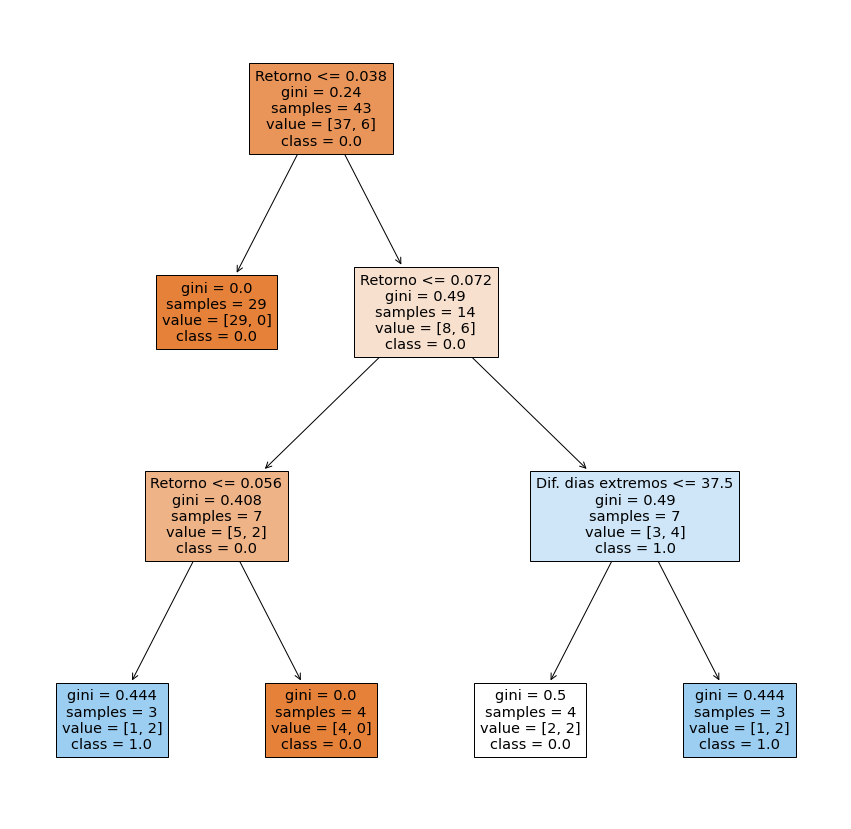

In [27]:
col = datos.drop("etiqueta",axis = 1).columns
clases = []
for i in range(dTree.classes_.shape[0]):
    clases.append(str(dTree.classes_[i]))

fig, ax = plt.subplots(figsize=(15,15))
_ = plot_tree(dTree, feature_names=col,
                            class_names=clases,
                            filled=True)

### Test del modelo

Aqui se reportan los resultados de evaluación del modelo entrenado con los datos de test previamente obtenidos.

Se utiliza el modelo para predecir las etiquetas asociadas a las características de los datos de entrenamiento junto con la probabilidad asociada por el modelo para la decisión del etiquetado.

In [28]:
test_predicted = dTree.predict(x_test)

In [29]:
print(dTree.classes_)
dTree.predict_proba(x_test)

[0. 1.]


array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.5       , 0.5       ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.33333333, 0.66666667],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.33333333, 0.66666667],
       [0.5       , 0.5       ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.5       , 0.5       ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.33333333, 0.66666667]])

In [30]:
pd.DataFrame({'label': y_test, 
              'predicted': test_predicted})

,label,predicted
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


### Resultados de evaluación

Se reportan las métricas que permiten evaluar el modelo.

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

**Matriz de confusión**

Obtenida con una función creada

In [32]:
def matriz_confusion(y_real, y_pred):
    real = pd.Series(y_real, name='Real')
    predicted = pd.Series(y_pred, name="Predicted")
    return pd.crosstab(real,predicted)

In [33]:
matriz_confusion(y_test, test_predicted)

Predicted,0.0,1.0
Real,,
0.0,25,1
1.0,2,2


Obtenida mediante la función de sklearn

In [34]:
matriz_conf = confusion_matrix(y_test, test_predicted)
matriz_conf

array([[25,  1],
       [ 2,  2]], dtype=int64)

**Resultado de accuracy y AUROC**

Se comprueba el accuracy del modelo y el AUROC de este (área debajo de a curva ROC)

In [35]:
accuracy = accuracy_score(y_test, test_predicted)
accuracy

0.9

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, test_predicted)
auroc = auc(fpr, tpr)
auroc

0.7307692307692307

Tanto el accuracy como el AUROC son buenos, teniendo un porcentaje muy alto de aciertos (reconocimiento del patrón) pese a equivocarse aun en un 10%. Para el AUROC, se obtiene un buen resultado, mayor de 0.7, pese a que aun esta lejos del modelo "perfecto" que obtendría 1 en esta métrica. Pese a los problemas del modelo, este muestra que resulta ser mejor que la aleatoriedad como se comprobará con la curva ROC.

**Curva ROC**


En el siguiente gráfico se muestra la curva ROC del modelo (en rojo), mientras que en verde se muestra la curva correspondiente a un modelo que representa la aleatoriedad.

In [38]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

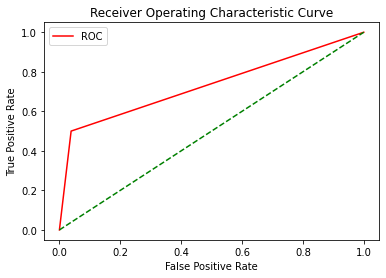

In [39]:
fper, tper, thresholds = roc_curve(y_test, test_predicted)
plot_roc_curve(fper, tper)

Como se puede observar, esta curva ROC está por encima de la del modelo aleatorio, demostrando que es mejor que la aleatoriedad. Sin embargo, esta curva indica tambien que no se ha llegado al modelo perfecto como indica el AUROC calculado anteriormente que, pese a ser bueno, sigue estando lejos de 1. A este modelo le falta robustez ya que la cantidad de datos de cada etiqueta no esta balanceado, encontrando muchas más etiquetas correspondientes a "no patrón" que a "doble suelo", y la cantidad de datos etiquetados no es muy grande por lo que puede caer en el problema de etiquetar todo con 0 obteniendo un buen accuracy pero sin ser capaz realmente de reconocer cuando hay patrón y cuando no. Pese a todo, el modelo es capaz de reconocer los patrones "doble suelo" como se puede comprobar en la matriz de confusión.

### Importancia de las características generadas

Se reporta la importancia las características generadas en el modelo junto con la importancia
por permutación

In [146]:
from sklearn.inspection import permutation_importance
r = permutation_importance(dTree, x_test, y_test,
                            n_repeats=100,
                            random_state=0)


In [129]:
r

{'importances_mean': array([0.11366667, 0.00466667, 0.        , 0.        , 0.        ]),
 'importances_std': array([0.04348563, 0.0170098 , 0.        , 0.        , 0.        ]),
 'importances': array([[ 0.16666667,  0.06666667,  0.13333333,  0.13333333,  0.13333333,
          0.13333333,  0.        ,  0.13333333,  0.        ,  0.13333333,
          0.06666667,  0.13333333,  0.16666667,  0.        ,  0.06666667,
          0.13333333,  0.13333333,  0.13333333,  0.16666667,  0.16666667,
          0.13333333,  0.06666667,  0.13333333,  0.16666667,  0.13333333,
          0.13333333,  0.13333333,  0.13333333,  0.13333333,  0.16666667,
          0.06666667,  0.13333333,  0.        ,  0.13333333,  0.13333333,
          0.        ,  0.1       ,  0.06666667,  0.1       ,  0.13333333,
          0.13333333,  0.13333333,  0.13333333,  0.13333333,  0.13333333,
          0.13333333,  0.06666667,  0.13333333,  0.13333333,  0.13333333,
          0.13333333,  0.06666667,  0.13333333,  0.06666667,  0.13

Importancia por permutación de las características

In [147]:
for i in r.importances_mean.argsort()[::-1]:
         print(f"{datos.columns[i]:<8} "
               f"{r.importances_mean[i]:.3f} "
               f" +/- {r.importances_std[i]:.3f} ")

Retorno  0.114  +/- 0.043 
Dif. dias extremos 0.005  +/- 0.017 
umbral2  0.000  +/- 0.000 
Orden extremos 0.000  +/- 0.000 
Nº veces cruce umbral 0.000  +/- 0.000 


Gráfico que muestra la importancia de las carácterísticas utilizadas por el modelo

Feature: 0, Score: 0.98317
Feature: 1, Score: 0.01683
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000


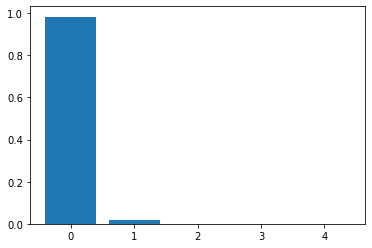

In [42]:
importance = dTree.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

La importancia de las características utilizadas esta muy poco balanceada, siendo el retorno la característica más importante con diferencia. Esto no es bueno para el modelo ya que aunque haya podido dar buenos resultados para los conjuntos de datos utilizados no es confiable utilizar solo 2 características, una en gran porcentaje, para el reconocimiento de distintos patrones. Es por esto que se ha decidido hacer otros dos modelos para ver otros ordenes de importancia de las características y su resultado en las métricas de evaluación.

## Modelo 2

Dado que el modelo anterior contaba con ciertos problemas y utlizaba en gran mayoría solo una características, se han creado otros dos modelos para ver el comportamiento de esas características en otros modelos además de reportar el comportamiento de estos en la identificación de patrones. Se usan los mismos datos de train y test utilizados para el modelo 1.

In [68]:
from sklearn.ensemble import GradientBoostingClassifier

Para este modelo se ha probado a utilizar el modelo de Gradient Boosting Classifier para probar otro modelo con funcionamiento distinto al anterior

### Entrenamiento modelo

In [75]:
gbc_model = GradientBoostingClassifier()
_ = gbc_model.fit(x_train, y_train)

### Test del modelo

In [118]:
test_predicted = gbc_model.predict(x_test)

In [119]:
test_predicted

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

### Resultados de evaluación

**Matriz de confusión**

In [120]:
matriz_conf = confusion_matrix(y_test, test_predicted)
matriz_conf

array([[24,  2],
       [ 2,  2]], dtype=int64)

**Resultado de accuracy y AUROC**

In [121]:
accuracy = accuracy_score(y_test, test_predicted)
accuracy

0.8666666666666667

In [122]:
fpr, tpr, thresholds = roc_curve(y_test, test_predicted)
auroc = auc(fpr, tpr)
auroc

0.7115384615384616

**Curva ROC**

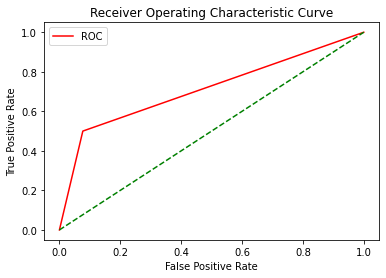

In [123]:
fper, tper, thresholds = roc_curve(y_test, test_predicted)
plot_roc_curve(fper, tper)

Para este modelo, se encuentran métricas buenas pese a ser inferiores a las obtenidas con el modelo 1. Este segundo modelo, sigue contando con el mismo problema de robustez que el modelo 1 y no obtiene una métricas mejores.

### Importancia de las características generadas

Feature: 0, Score: 0.56745
Feature: 1, Score: 0.24984
Feature: 2, Score: 0.01779
Feature: 3, Score: 0.00029
Feature: 4, Score: 0.16463


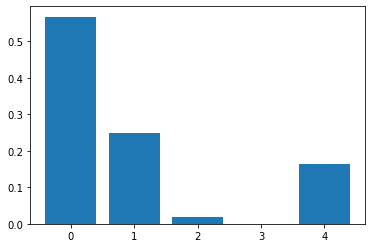

In [124]:
importance = gbc_model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [149]:
r = permutation_importance(gbc_model, x_test, y_test,
                            n_repeats=100,
                            random_state=0)
for i in r.importances_mean.argsort()[::-1]:
         print(f"{datos.columns[i]:<8}: "
               f"{r.importances_mean[i]:.3f}: "
               f" +/- {r.importances_std[i]:.3f}: ")

Retorno : 0.085:  +/- 0.053: 
umbral2 : 0.005:  +/- 0.012: 
Dif. dias extremos: 0.001:  +/- 0.023: 
Orden extremos: 0.000:  +/- 0.000: 
Nº veces cruce umbral: 0.000:  +/- 0.000: 


En este modelo, la importancia de las características esta más balanceada que en el anterior modelo, siendo más número de estas la utilizadas por el modelo para identificar los patrones lo que permite que este modelo sea menos dependiente de una sola variable predictora que el anterior.

## Modelo 3

Para este tercer modelo, se ha añadido una característica nueva (el coeficiente de variación) y se ha utilizado un Random Forest Classifier como modelo.

In [194]:
def obtener_caract_datos_rf (datos_ohlc,doble_suelo_labels):
    """
    """

    columnas = ["Retorno", "Dif. dias extremos",
                "Nº veces cruce umbral",
                "Orden extremos",
                "umbral2",
                "coef_variacion"
               ]
    datos_caract = pd.DataFrame(columns = columnas)
    for i in datos_ohlc.keys():
        data = datos_ohlc[i]
        r = retorno_ventana(data)
        dif_dias = dif_dias_max_min (data)
        n_cruc_umbral = cruce_umbral (data,
                                      porcent_umbral = 0.1
                                     )
        n_cruc_umbral2 = cruce_umbral2 (data,porcent_umbral = 0.1)
        orden_extremos = orden_max_min (data)
        coef_var = coef_variacion (data)
        caract = [r,dif_dias,n_cruc_umbral,orden_extremos,n_cruc_umbral2,coef_var]#,cos_med]
        caract = pd.DataFrame([caract],columns = columnas)
        datos_caract = pd.concat([datos_caract,caract],axis = 0)
    
    datos_caract = datos_caract.reset_index().drop("index",axis = 1)
    datos_caract = pd.concat([datos_caract,doble_suelo_labels.etiqueta],axis = 1)

    return datos_caract

In [195]:
datos2 = obtener_caract_datos_rf (datos_ohlc,doble_suelo_labels)
datos2

,Retorno,Dif. dias extremos,Nº veces cruce umbral,Orden extremos,umbral2,coef_variacion,etiqueta
0,-0.025358,20,5,0,5,0.014932,0.0
1,-0.024946,30,4,0,2,0.016140,0.0
2,-0.022112,28,6,1,2,0.023567,0.0
3,0.023688,28,3,1,4,0.021231,0.0
4,-0.031108,17,2,1,3,0.023355,0.0
...,...,...,...,...,...,...,...
68,-0.030771,9,2,0,4,0.014804,0.0
69,0.036967,22,3,1,4,0.026987,0.0
70,-0.006559,10,1,0,2,0.017251,0.0
71,0.112265,36,1,1,3,0.036727,0.0


Pese a ser las mismas ventanas etiquetadas, al introducir la nueva característica, se tiene que volver a realizar la obtención de las características asociadas a los datos OHLC y la separación de los datos en train y test

In [211]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(datos2.drop("etiqueta",axis = 1).values,
                                                    datos2.etiqueta.values,
                                                    test_size=0.4,
                                                    stratify=datos.etiqueta.values)

### Entrenamiento modelo 

In [156]:
from sklearn.ensemble import RandomForestClassifier

In [212]:
rf_model = RandomForestClassifier(n_estimators = 200)
_ = rf_model.fit(x_train2, y_train2)

### Test modelo 

In [213]:
test_predicted2 = rf_model.predict(x_test2)

### Resultados de evaluación

**Matriz de confusión**

In [214]:
matriz_conf = confusion_matrix(y_test2, test_predicted2)
matriz_conf

array([[24,  2],
       [ 3,  1]], dtype=int64)

**Resultado de accuracy y AUROC**

In [215]:
accuracy = accuracy_score(y_test2, test_predicted2)
accuracy

0.8333333333333334

In [216]:
fpr, tpr, thresholds = roc_curve(y_test2, test_predicted2)
auroc = auc(fpr, tpr)
auroc

0.5865384615384616

**Curva ROC**

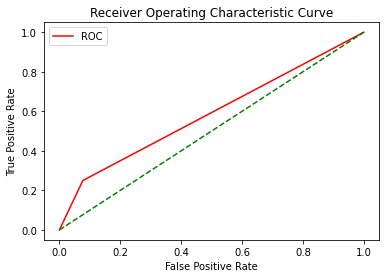

In [217]:
plot_roc_curve(fpr, tpr)

Este modelo a resultado ser peor que los anteriores aunque no es comparable al tener una característica más y unos datos de entrenamiento y test distintos.El modelo tiene un buen porcentaje de aciertos igual que los anteriores, sin embargo el AUROC es mucho peor debido a que reconoce sin problemas las gráficas sin patrón pero tiene un porcentaje de aciertos muy bajo para las gráficas de doble suelo. Esto puede ser debido a que tanto en los datos de train como en los de test, las clases no estan balanceadas y ademas se cuenta con poco datos como para que el modelo cuente con la máxima robustez y generalidad a la hora de reconocer los patrones. Sin embargo, como tambien se refleja en el gráfico de la curva ROC, el modelo es mejor que la aleatoriedad pese a contar con un error importante a la hora de etiquetar los patrones doble suelo pudiendo caer facilmente en el error de asociar la etiqueta de sin patrón a la mayoría de ventanas que evalúa.

### Importancia de las características generadas

Feature: 0, Score: 0.35714
Feature: 1, Score: 0.17455
Feature: 2, Score: 0.10018
Feature: 3, Score: 0.04594
Feature: 4, Score: 0.07664
Feature: 5, Score: 0.24555


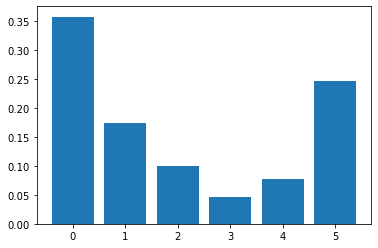

In [220]:
importance = rf_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [223]:
r = permutation_importance(rf_model, x_test2, y_test2,
                            n_repeats=10,
                            random_state=0)
for i in r.importances_mean.argsort()[::-1]:
         print(f"{datos2.columns[i]:<8}: "
               f"{r.importances_mean[i]:.3f}: "
               f" +/- {r.importances_std[i]:.3f}: ")

coef_variacion: 0.010:  +/- 0.037: 
Nº veces cruce umbral: 0.003:  +/- 0.010: 
umbral2 : -0.010:  +/- 0.015: 
Retorno : -0.010:  +/- 0.030: 
Orden extremos: -0.013:  +/- 0.022: 
Dif. dias extremos: -0.020:  +/- 0.016: 
